In [3]:
import numpy as np
import matplotlib.pyplot as pl
from spectral import *
import matplotlib as mpl
import spectral.io.envi as envi
from os import listdir

# Read and Calibrate

In [4]:
def read_image(ID,rwdt=None):
    if rwdt=='raw':
        fn = '../data/HSI/%s/raw'%ID
        fn_hdr = '../data/HSI/%s/raw.hdr'%ID
        
    elif rwdt=='white':
        fn = '../data/HSI/%s/whiteReference'%ID
        fn_hdr = '../data/HSI/%s/whiteReference.hdr'%ID
        
    elif rwdt=='dark':
        fn = '../data/HSI/%s/darkReference'%ID
        fn_hdr = '../data/HSI/%s/darkReference.hdr'%ID
        
    elif rwdt=='truth':
        fn = '../data/HSI/%s/gtMap'%ID
        fn_hdr = '../data/HSI/%s/gtMap.hdr'%ID
        
    img = envi.open(fn_hdr, fn)
    arr = img.load()
    
    
    if rwdt!='truth':
        arr = arr[:,:,57:-126]
        
    else:
        pass
    
    
    return arr




def calibrate(ID,step=10):
    r = np.array(read_image(ID,rwdt='raw'))
    d = np.array(read_image(ID,rwdt='dark'))[0]
    w = np.array(read_image(ID,rwdt='white'))[0]
    


    d2 = d.reshape((1,d.shape[0],d.shape[1]))
    w2 = w.reshape((1,w.shape[0],w.shape[1]))
    
    


    d2 = d2*np.ones_like(r)
    w2 = w2*np.ones_like(r)


    
    cal = (r - d2)/(w2-d2)
    
    inds = np.arange(cal.shape[-1])[::step]
    
    cal = cal[:,:,inds]

    mins = np.min(cal,axis=-1,keepdims=True)
    maxs = np.max(cal,axis=-1,keepdims=True)
    cal = (cal - mins)/(maxs-mins)
    return cal
    

    

# Generate cutout images

In [33]:
import numpy as np


def random_flip(image):
    flip_x, flip_y = np.random.choice([True, False],size=2)
    if flip_x:
        image = np.flip(image, axis=0)
    if flip_y:
        image = np.flip(image, axis=1)
    return image



def check_box_fit(image, point, pad=8):
    height, width = image.shape
    #x, y = point
    y, x = point
    
    if x - pad >= 0 and x + pad < width and y - pad >= 0 and y + pad < height:
        return True
    else:
        return False

In [36]:
def generate_images(ID, imagesize=17):
    #ID = '008-01'

    np.random.seed(0)

    pad = (imagesize-1)/2

    truth = read_image(ID,rwdt='truth')[:,:,0]
    truth = truth.reshape((truth.shape[0],truth.shape[1]))
    raw = calibrate(ID)

    where_label = np.where(truth!=0)
    where_tumor_OG = np.where(truth==2)
    where_normal_OG = np.where(truth==1)
    where_hyper_OG = np.where(truth==3)
    where_back_OG = np.where(truth==4)

    where_tumor = []
    for w in range(len(where_tumor_OG[0])):
        point = [where_tumor_OG[0][w],where_tumor_OG[1][w]]
        if check_box_fit(truth, point, pad=pad):
            where_tumor.append(point)
    where_tumor = np.array(where_tumor).T

    where_normal = []
    for w in range(len(where_normal_OG[0])):
        point = [where_normal_OG[0][w],where_normal_OG[1][w]]
        if check_box_fit(truth, point, pad=pad):
            where_normal.append(point)
    where_normal = np.array(where_normal).T

    where_hyper = []
    for w in range(len(where_hyper_OG[0])):
        point = [where_hyper_OG[0][w],where_hyper_OG[1][w]]
        if check_box_fit(truth, point, pad=pad):
            where_hyper.append(point)
    where_hyper = np.array(where_hyper).T

    where_back = []
    for w in range(len(where_back_OG[0])):
        point = [where_back_OG[0][w],where_back_OG[1][w]]
        if check_box_fit(truth, point, pad=pad):
            where_back.append(point)
    where_back = np.array(where_back).T
    




    #if any([where_normal[0].size,where_tumor[0].size,where_hyper[0].size,where_back[0].size])==0:
    #    return
    
    min_labels = np.min([where_normal[0].size,where_tumor[0].size,where_hyper[0].size,where_back[0].size])
    print(min_labels)
    print('')


    

    inds_normal = np.random.choice(np.arange(0,where_normal[0].size),size=min_labels,replace=False)
    inds_tumor = np.random.choice(np.arange(0,where_tumor[0].size),size=min_labels,replace=False)
    inds_hyper = np.random.choice(np.arange(0,where_hyper[0].size),size=min_labels,replace=False)
    inds_back = np.random.choice(np.arange(0,where_back[0].size),size=min_labels,replace=False)
    


    print(truth.shape)
    

    for i, ind in enumerate(inds_normal):
        t = int(truth[where_normal[0][i],where_normal[1][i]] - 1)
        truth_classes = np.zeros(4)
        truth_classes[t] = 1
        #truth_images = truth[int(where_label[0][ind]-pad):int(where_label[0][ind]+pad+1),int(where_label[1][ind]-pad):int(where_label[1][ind]+pad+1)]
        data_images = raw[int(where_normal[0][ind]-pad):int(where_normal[0][ind]+pad+1),\
                          int(where_normal[1][ind]-pad):int(where_normal[1][ind]+pad+1),:]
        
        if data_images.shape != (imagesize,imagesize,65):
            print('data_images shape (normal):',data_images.shape)
            print(where_normal[0][ind], int(where_normal[0][ind]-pad),int(where_normal[0][ind]+pad+1))
            print([j for j in range(int(where_normal[0][ind]-pad),int(where_normal[0][ind]+pad+1))])
            
        
        

        fn_x = '../data/X_new/%s_%i_%i.npy'%(ID,i,t)
        fn_y = '../data/Y_new/%s_%i_%i.npy'%(ID,i,t)
        np.save(fn_x,random_flip(data_images))
        np.save(fn_y,truth_classes)



    for i, ind in enumerate(inds_tumor):
        t = int(truth[where_tumor[0][i],where_tumor[1][i]] - 1)
        truth_classes = np.zeros(4)
        truth_classes[t] = 1
        #truth_images = truth[int(where_label[0][ind]-imagesize/2):int(where_label[0][ind]+imagesize/2+1),int(where_label[1][ind]-imagesize/2):int(where_label[1][ind]+imagesize/2+1)]
        data_images = raw[int(where_tumor[0][ind]-pad):int(where_tumor[0][ind]+pad+1),\
                          int(where_tumor[1][ind]-pad):int(where_tumor[1][ind]+pad+1),:]
        
        if data_images.shape != (imagesize,imagesize,65):
            print('data_images shape (tumor):',data_images.shape)
            print(where_tumor[0][ind], int(where_tumor[0][ind]-pad),int(where_tumor[0][ind]+pad+1))
            print([j for j in range(int(where_tumor[0][ind]-pad),int(where_tumor[0][ind]+pad+1))])
        
        

        fn_x = '../data/X_new/%s_%i_%i.npy'%(ID,i,t)
        fn_y = '../data/Y_new/%s_%i_%i.npy'%(ID,i,t)
        
        np.save(fn_x,random_flip(data_images))
        np.save(fn_y,truth_classes)

    
    for i, ind in enumerate(inds_hyper):
        t = int(truth[where_hyper[0][ind],where_hyper[1][ind]] - 1)
        truth_classes = np.zeros(4)
        truth_classes[t] = 1
        #truth_images = truth[int(where_label[0][ind]-imagesize/2):int(where_label[0][ind]+imagesize/2+1),int(where_label[1][ind]-imagesize/2):int(where_label[1][ind]+imagesize/2+1)]
        data_images = raw[int(where_hyper[0][ind]-pad):int(where_hyper[0][ind]+pad+1),\
                          int(where_hyper[1][ind]-pad):int(where_hyper[1][ind]+pad+1),:]
        
        if data_images.shape != (imagesize,imagesize,65):
            print('data_images shape (hyper):',data_images.shape)
            print(where_hyper[0][ind], int(where_hyper[0][ind]-pad),int(where_hyper[0][ind]+pad+1))
            print([j for j in range(int(where_hyper[0][ind]-pad),int(where_hyper[0][ind]+pad+1))])
        
        

        fn_x = '../data/X_new/%s_%i_%i.npy'%(ID,i,t)
        fn_y = '../data/Y_new/%s_%i_%i.npy'%(ID,i,t)
        
        np.save(fn_x,random_flip(data_images))
        np.save(fn_y,truth_classes)

    for i, ind in enumerate(inds_back):
        t = int(truth[where_back[0][ind],where_back[1][ind]] - 1)
        truth_classes = np.zeros(4)
        truth_classes[t] = 1
        #truth_images = truth[int(where_label[0][ind]-pad):int(where_label[0][ind]+pad+1),int(where_label[1][ind]-imagesize/2):int(where_label[1][ind]+imagesize/2+1)]
        data_images = raw[int(where_back[0][ind]-pad):int(where_back[0][ind]+pad+1),\
                          int(where_back[1][ind]-pad):int(where_back[1][ind]+pad+1),:]
        
        if data_images.shape != (imagesize,imagesize,65):
            print('data_images shape (back):',data_images.shape)
            print(where_back[0][ind], int(where_back[0][ind]-pad),int(where_back[0][ind]+pad+1))
            print(where_back[1][ind], int(where_back[1][ind]-pad),int(where_back[1][ind]+pad+1))
            print([j for j in range(int(where_back[0][ind]-pad),int(where_back[0][ind]+pad+1))])
            print([j for j in range(int(where_back[1][ind]-pad),int(where_back[1][ind]+pad+1))])
        
        

        fn_x = '../data/X_new/%s_%i_%i.npy'%(ID,i,t)
        fn_y = '../data/Y_new/%s_%i_%i.npy'%(ID,i,t)
        
        np.save(fn_x,random_flip(data_images))
        np.save(fn_y,truth_classes)

    


In [37]:
import os
from os import listdir

d = '../data/HSI/'




for ID in sorted(listdir(d)):
    if '.txt' in ID:
        continue


    #if ID!='012-02':
    #    continue



    print(ID)

    t = read_image(ID,rwdt='truth')
    if 1 in t and 2 in t and 3 in t:
        print('%s has normal/tumor/hyper'%ID)
        generate_images(ID,imagesize=17)

    else:
        continue

    

    

004-02
005-01
007-01
008-01
008-01 has normal/tumor/hyper
630

(460, 549)
008-02
008-02 has normal/tumor/hyper
138

(480, 553)
010-03
012-01
012-01 has normal/tumor/hyper
855

(443, 497)
012-02
012-02 has normal/tumor/hyper
3139

(445, 498)
013-01
014-01
015-01
015-01 has normal/tumor/hyper
696

(376, 494)
016-01
016-02
016-03
016-04
016-05
017-01
018-01
018-02
019-01
020-01
020-01 has normal/tumor/hyper
1513

(378, 330)
021-01
021-01 has normal/tumor/hyper
240

(452, 334)
021-02
021-02 has normal/tumor/hyper
32

(448, 324)
021-05
022-01
022-02
022-03
025-02
025-02 has normal/tumor/hyper
907

(473, 403)
026-02
027-02
028-03
028-04
028-05
029-02
029-04
030-02
034-01
034-02
034-03
035-01
035-02
036-01
036-02
036-02 has normal/tumor/hyper
888

(432, 322)
037-01
037-02
037-03
037-04
038-01
038-01 has normal/tumor/hyper
2295

(497, 490)
039-01
039-01 has normal/tumor/hyper
244

(415, 446)
039-02
039-02 has normal/tumor/hyper
822

(399, 439)
040-01
040-01 has normal/tumor/hyper
394

(303, 37

# End

In [6]:
x = np.load('../data/X_new/008-02_0_2.npy')
y = np.load('../data/Y_new/008-02_0_2.npy')

In [7]:
x.shape

(17, 17, 65)

In [140]:
for fn in sorted(listdir('../data/X_new')):
    x = np.load('../data/X_new/'+fn)
    if x.shape!=(17,17,17):
        print(x.shape)
        print(fn)

(0, 17, 17)
008-02_21_3.npy


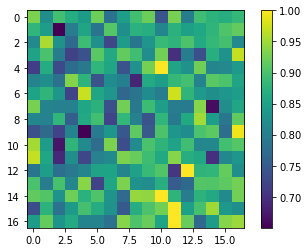

[0. 0. 1. 0.]


In [136]:
pl.imshow(x[:,:,10])
pl.colorbar()
pl.show()
print(y)